# Amazon reviews report

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

import altair as alt
import re

from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to C:\Users\Harold Uribe
[nltk_data]     Romero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Harold Uribe
[nltk_data]     Romero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Step 1: Set the path to the folder containing your files
folder_path = '../factored-datathon-2023-data-science-rockstars/final_ahora_si_talvez/Agrupado'

# Step 2: List all the files in the folder
file_list = os.listdir(folder_path)

# Initialize an empty list to store DataFrames
dfs = []

# Step 3: Read each file into a DataFrame and store in the list
for file_name in file_list:
    # Replace '.csv' with the appropriate file extension
    if file_name.endswith('.gzip'):
        file_path = os.path.join(folder_path, file_name)
        # Use the appropriate read function for your file type
        df = pd.read_parquet(file_path, engine='fastparquet')
        dfs.append(df)

# Step 4: Concatenate the DataFrames into a single one
concatenated_df = pd.concat(dfs, ignore_index=True)
concatenated_df = concatenated_df.query('overall != 0')
# Now, 'concatenated_df' contains all the data from the files in a single DataFrame.


In [3]:
# Step 1: Set the path to the folder containing your files
folder_path = '../factored-datathon-2023-data-science-rockstars/final_ahora_si_talvez/Games'

# Step 2: List all the files in the folder
file_list = os.listdir(folder_path)

# Initialize an empty list to store DataFrames
dfs = []

# Step 3: Read each file into a DataFrame and store in the list
for file_name in file_list:
    # Replace '.csv' with the appropriate file extension
    if file_name.endswith('.gzip'):
        file_path = os.path.join(folder_path, file_name)
        # Use the appropriate read function for your file type
        df = pd.read_parquet(file_path, engine='fastparquet')
        dfs.append(df)

# Step 4: Concatenate the DataFrames into a single one
df_games = pd.concat(dfs, ignore_index=True)
df_games = df_games.query('overall != 0')
# Now, 'concatenated_df' contains all the data from the files in a single DataFrame.


In [4]:
concatenated_df['Year'] = concatenated_df['YearMonth'].astype(
    str).str[:4].astype('int16')
concatenated_df['Month'] = concatenated_df['YearMonth'].astype(
    str).str[4:].astype('int16')


In [5]:
df_trend = concatenated_df.groupby(['Year', 'Month', 'overall']).agg({'total_count': 'sum', 'distinct_count': 'sum', 'votes_sum': 'sum'}).sort_values(
    by=['Year', 'Month', 'overall'], ascending=[True, True, False]).reset_index()
df_trend['Year-Month'] = concatenated_df['Year'].astype(
    str) + '-' + concatenated_df['Month'].astype(str)
df_trend['frequent_reviewers_percentage'] = (
    1 - np.divide(df_trend['distinct_count'], df_trend['total_count']))*100
df_trend['overall'] = df_trend['overall'].astype(str)


In [6]:
df_trend = df_trend.query('Year <= 2018 and Month <= 5')


### Report

### 1. Introduction
In this report we examine data related to Amazon product reviews. In the first part, we focus on giving an overview of the behaviour of reviews as rated by users. In the second part, we perform a sentiment analysis on some reviews.

### 2. Overview

During the data exploration phase we noticed that many more users gave a rating of 5 than chose one of the other four ratings. Therefore, this general analysis focuses on examining the behaviour of each rating.

In this first graph,"Number of reviewers by overall rating",we show the behaviour of each rating over time according to the number of users who gave that rating, for each month. The number of users is the number of unique user identifications that have given this rating to a product.
In the graph, we can see that the rating of 5 is the predominant one, it increased exponentially since the second quarter of 2012 and maintained the growth until the second quarter of 2016. We can see that the second most important rating is the 4, which has maintained a more stable behaviour compared to the 5, but is still far behind the first one. The remaining ratings have a similar number of users over time.

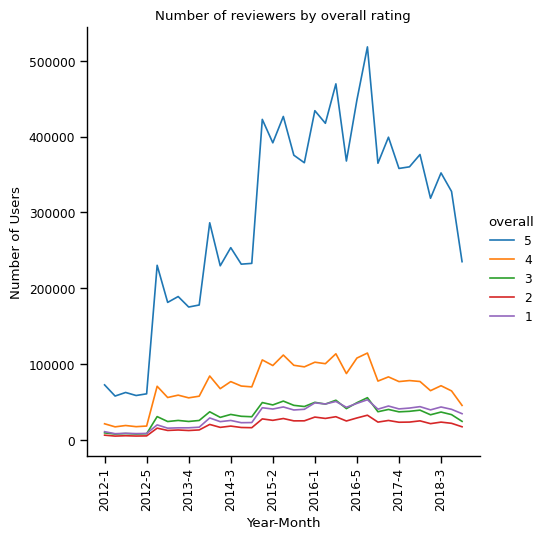

In [7]:

sns.set_context('paper')
sns.relplot(data=df_trend, x='Year-Month',
            y='distinct_count', hue='overall', kind='line')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.title('Number of reviewers by overall rating')
plt.ylabel('Number of Users')
plt.xticks(rotation=90)

plt.show()


Seeing the difference in the graph above made us think that there might be users who frequently give 5 stars to multiple products, thus inflating the statistic. Therefore, for each type of rating, we looked at the percentage of users who have rated two or more times, this calculation is the comparison between the total number of ratings or user identifications and the number of unique user identifications that have rated a product.
The result of this analysis can be seen in the graph **"Percentage of frequent reviewers by total rating"**, where we can see that high ratings, 5 and 4, tend to have more frequent reviewers. We can also see that the 5 rating comes out on top again, with an average difference of 3% more frequent reviewers than the 4 rating. 
* For the overall rating of 5, we have 6% to 7% of frequent reviewers
* For the overall rating of 5, we have 4% to 4.5% of frequent reviewers

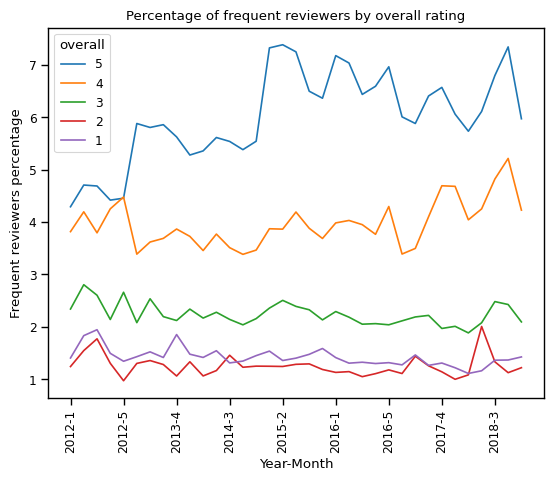

In [8]:

sns.lineplot(data=df_trend, x='Year-Month',
             y='frequent_reviewers_percentage', hue='overall')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.title('Percentage of frequent reviewers by overall rating')
plt.ylabel('Frequent reviewers percentage')
plt.show()


In addition to users by rating, we analysed the number of interactions or votes each review had according to its rating, as we noticed during the data exploration phase and confirmed in this report that people interact more with the 5-point reviews than the rest. 

As we can see in the "Votes by overall rating" graph, the 5 point reviews have a much higher average than the other ratings. We can also see that reviews with a score of 1 receive more interactions than those with a score of 5. 
From this graph, we can see that the distribution of interactions is skewed towards the extremes of 5 and 1, and that the growth seen from 2 point reviews to 4 is interrupted by the abrupt increase in interactions of the overall rating of 5.

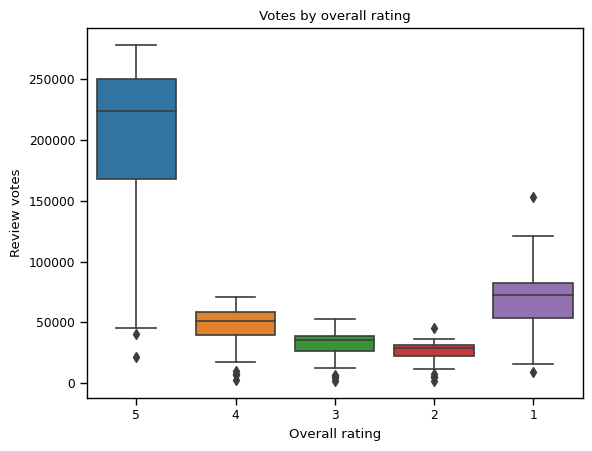

In [9]:

sns.boxplot(data=df_trend, x="overall", y="votes_sum")
plt.title('Votes by overall rating')
plt.xlabel('Overall rating')
plt.ylabel('Review votes')
plt.show()


In the same way as the previous graph, we explored the possible relationship between the number of users who are frequent reviewers and the number of votes a review receives. In the following, we present the correlation graph "Frequent reviewers and number of interactions" according to the overall rating. 

We see that there is no clear correlation between these two variables. However, we confirm the phenomenon that reviews with an overall rating of 5 show a completely different behaviour to the other ratings.


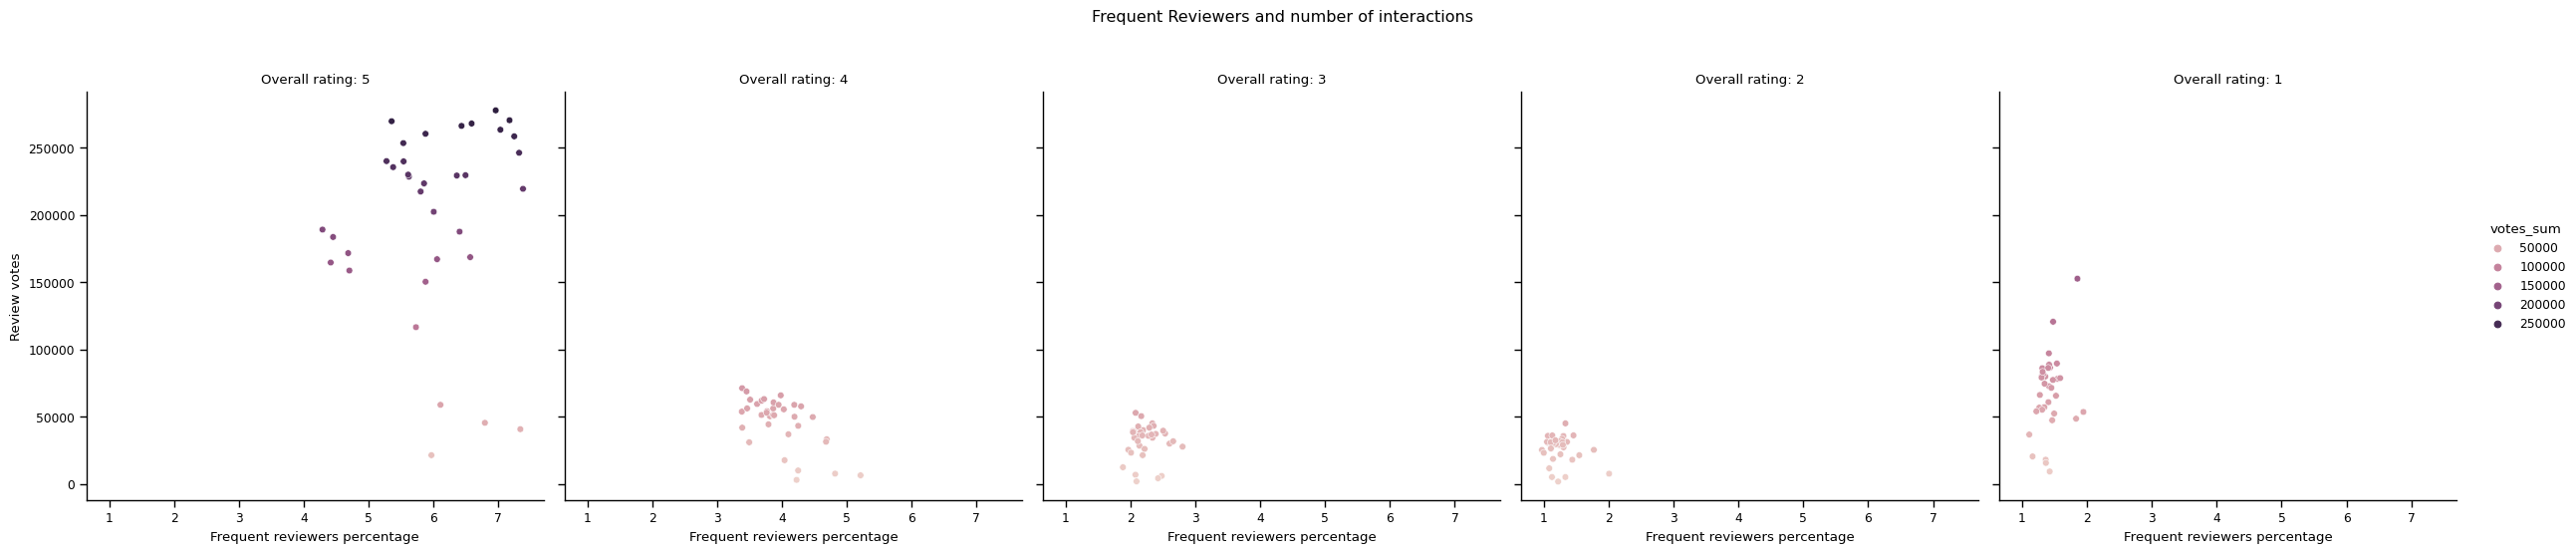

In [10]:

rel = sns.relplot(data=df_trend, x='frequent_reviewers_percentage',
                  y='votes_sum', kind='scatter', col='overall', hue='votes_sum')
rel.fig.suptitle('Frequent Reviewers and number of interactions', y=1.1)
rel.set(xlabel='Frequent reviewers percentage', ylabel='Review votes')
rel.set_titles("Overall rating: {col_name}")
plt.show()


Finally, we show the correlation matrix between the number of users who frequently review and the number of votes or interactions the review has received.
We have a correlation index of 0.7, which leads us to believe that there is a strong correlation between these two variables. However, from what we saw earlier, we know that this may be skewed by the 5 star reviews.


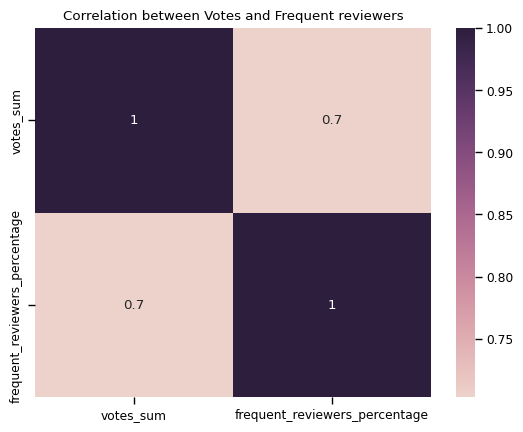

In [11]:

sns.heatmap(df_trend[['votes_sum', 'frequent_reviewers_percentage']].corr(
), label=True, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Correlation between Votes and Frequent reviewers')
plt.show()


-----------------------
## Games and Tech Analysis
Considering that video games and technology are having a widespread use and an important growth potential, we have decided to make a deep dive in this type of products in order to analyze the sentiment and possible actionable from the company to maintain and improve customer service throughout the customer journey so that Amazon becomes the main platform for buying technology.

In [12]:
df = pd.read_parquet('Output\df_filtered_concat.parquet')
# df

## Review Type Assignment

According to the evaluation of the sentiment model we use (Roberta), we make a classification of the type of review by simple comparison between the scores.

The label was assigned according to the highest score obtained in the sentiment analysis of the review.

In [13]:
def review_category(row):
    if row['negative'] > row['positive'] and row['negative'] > row['neutral']:
        return 'negative'
    elif row['positive'] > row['negative'] and row['positive'] > row['neutral']:
        return 'positive'
    else:
        return 'neutral'

In [14]:
df['review_type'] = df.apply(review_category, axis=1)
# df.sample(1)

## Inspection of significant categories

In [15]:
count_per_style = df["style"].value_counts().reset_index()
count_per_style.columns = ['style', 'Count']
# len(count_per_style['style'].unique())
alt.Chart(count_per_style).mark_bar().encode(
    x=alt.X('style:N',sort=alt.EncodingSortField(field='Count', order='descending')
        ,axis=alt.Axis(title='Style Category')),
    y=alt.Y('Count:Q', axis=alt.Axis(title='Count')),
    tooltip=[
        alt.Tooltip('style:N', title='style'),
        alt.Tooltip('Count:Q', title='Count')
    ]
).properties(
    title='Count per Style Category'
).interactive()

alt.Chart(...)

Having 316 different categories in the dataframe, it has been decided to keep the categories with more than 90 reviews.

In [16]:
count_per_style = count_per_style[count_per_style['Count'] > 90]
alt.Chart(count_per_style).mark_bar().encode(
    x=alt.X('style:N',sort=alt.EncodingSortField(field='Count', order='descending')
        ,axis=alt.Axis(title='Style Category')),
    y=alt.Y('Count:Q', axis=alt.Axis(title='Count')),
    tooltip=[
        alt.Tooltip('style:N', title='style'),
        alt.Tooltip('Count:Q', title='Count')
    ]
).properties(
    title='Count per Style Category'
).interactive()

alt.Chart(...)

In [17]:
style_filtered = count_per_style[count_per_style['Count'] > 90]['style']
# style_filtered

df= df[df['style'].isin(style_filtered)].copy()
# df2.sample(5)

Once the dataframe with the style tags with the highest number of reviews was filtered, it is assigned a category. In this case, 3 main categories were defined that contain all the tags: Game, PC, Plattform.

In [18]:
condiciones = [
    df["style"].str.contains("game", case=False),
    df["style"].str.contains("pc|mac", case=False),
    df["style"].str.contains("playstation|xbox", case=False, regex=True)
]
valores = ["Game", "PC", "Platform"]

# Asignar la columna "categoria" basada en las condiciones
df["review_category"] = np.select(condiciones, valores, default="Other")

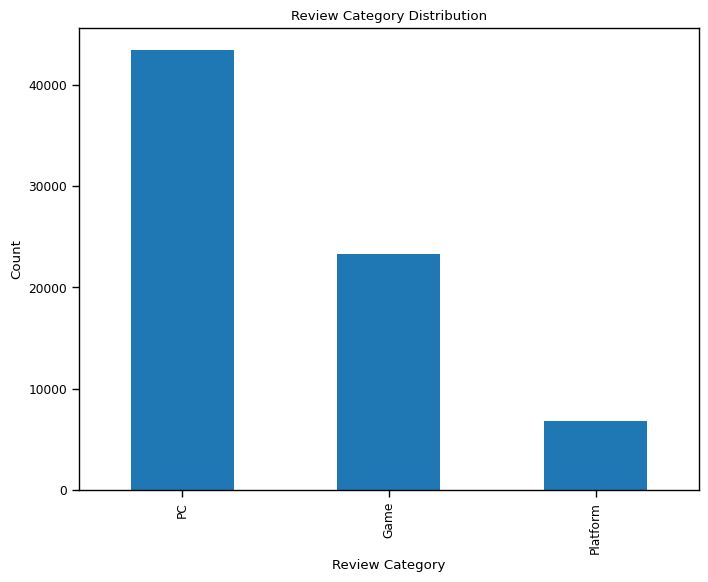

In [19]:
# disable chained assignments
df['review_category'].value_counts().plot(kind='bar', title='Review Category Distribution', figsize=(8, 6))
plt.xlabel('Review Category')
plt.ylabel('Count')

plt.grid(False)
plt.gca().set_facecolor('white')

plt.show()

----------------------

## Evaluation Model

Usually customers who leave good ratings about a product, usually leave a good review. We want to observe if the implemented sentiment analysis model is able to adequately recognize the sentiment of the reviews.


In [20]:
def stacked_bar(cross_tab,title, xlabel, ylabel):
    colors = ['tab:green', 'tab:blue', 'tab:orange']

    cross_tab.plot(kind='barh', 
                            stacked=True, 
                            figsize=(10, 6))

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # plt.ylabel("Review Category")
    # plt.xlabel("Proportion")
    plt.xticks([])
    # Quitar la rejilla
    plt.grid(False)
    # Establecer el fondo como blanco
    plt.gca().set_facecolor('white')



    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab.loc[x], cross_tab.loc[x].cumsum()):
            plt.text(
                x=y_loc - proportion /2 -0.03,
                y=n,
                s=f'{np.round(proportion * 100, 1)}%',
                color="black",
                fontsize=11,
                fontweight="bold")

    plt.show()

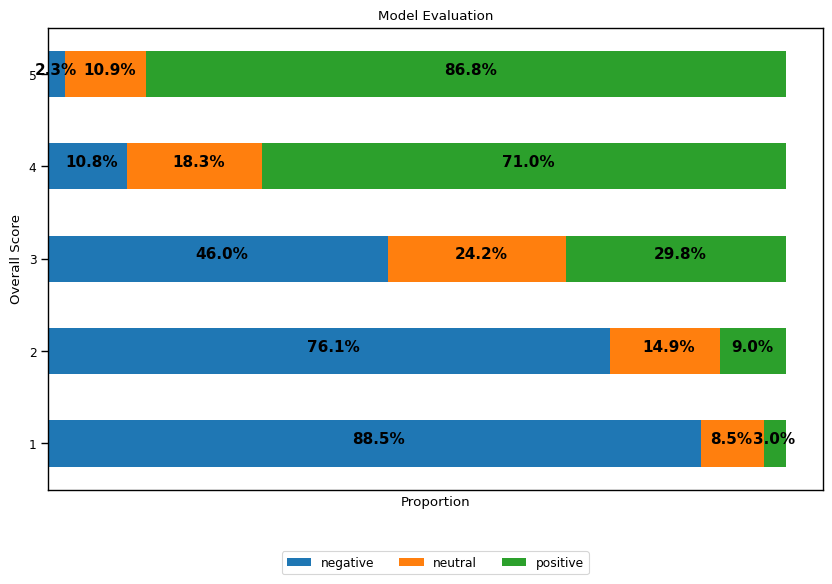

In [21]:
cross_tab_model = pd.crosstab(index=df['overall'],
                        columns=df['review_type'],
                        normalize='index')

stacked_bar(cross_tab_model,'Model Evaluation','Proportion','Overall Score')

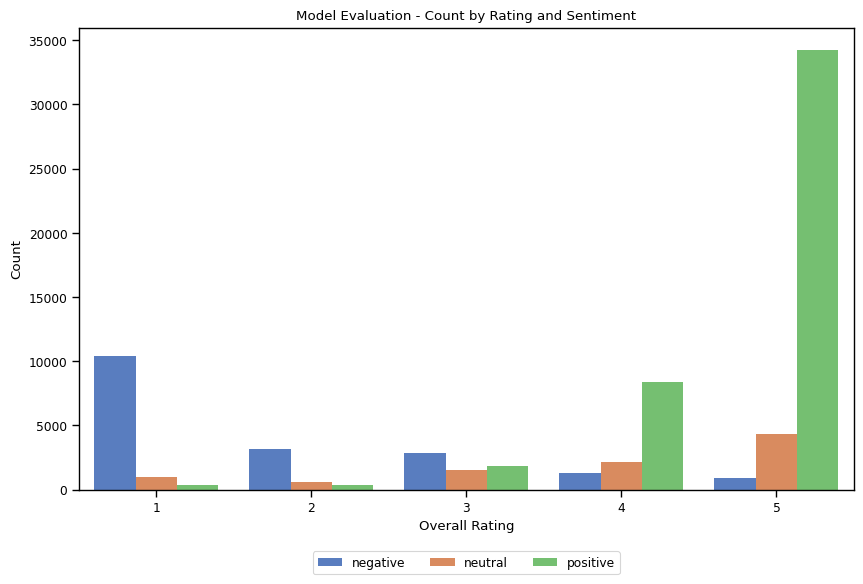

In [22]:
orden_review_type = ["negative", "neutral", "positive"]
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', hue='review_type'
    ,hue_order=orden_review_type
    , data=df, palette='muted')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.title('Model Evaluation - Count by Rating and Sentiment')

plt.grid(False)
plt.gca().set_facecolor('white')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
plt.show()

Despite having an unbalanced dataframe (with more reviews towards higher overall scores), it can be observed that the sentiment analysis model is able to give appropriate weights to the scores. 

-----------------------------------------------------------------------------------------------------------------------------------

## Analysis by category

With the classification by category that was done previously, it is possible to make a deep dive in the analysis by each of these categories and see the behavior of the reviews in each one of them.

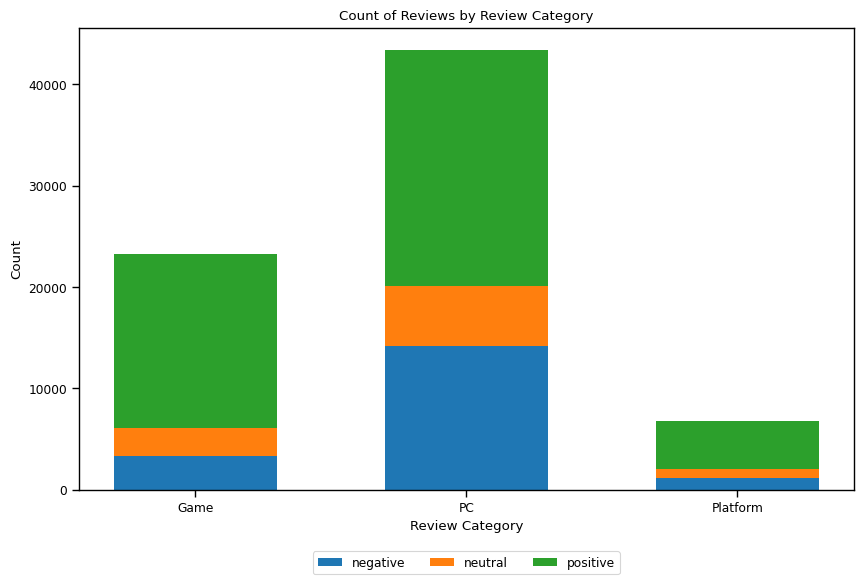

In [23]:
# Realizamos una tabla de frecuencias cruzadas entre 'review_category' y 'review_type'
cross_tab_2 = pd.crosstab(df['review_category'], df['review_type'])

# Utilizamos la función bar() de Matplotlib para crear el countplot apilado
plt.figure(figsize=(10, 6))

# Creamos un array de índices para ubicar las barras apiladas
index = range(len(cross_tab_2.index))

# Colores para cada tipo de revisión
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Creamos las barras apiladas para cada tipo de revisión
bottom = None
for i, review_type in enumerate(cross_tab_2.columns):
    values = cross_tab_2[review_type].values
    plt.bar(index, values, width=0.6, bottom=bottom, label=review_type, color=colors[i])
    if bottom is None:
        bottom = values
    else:
        bottom += values

# Establecemos las etiquetas del eje X
plt.xticks(index, cross_tab_2.index)

plt.xlabel("Review Category")
plt.ylabel("Count")
plt.title('Count of Reviews by Review Category')
# Quitar la rejilla
plt.grid(False)
# Establecer el fondo como blanco
plt.gca().set_facecolor('white')

# Colocar la leyenda en la parte superior del gráfico
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)

plt.show()


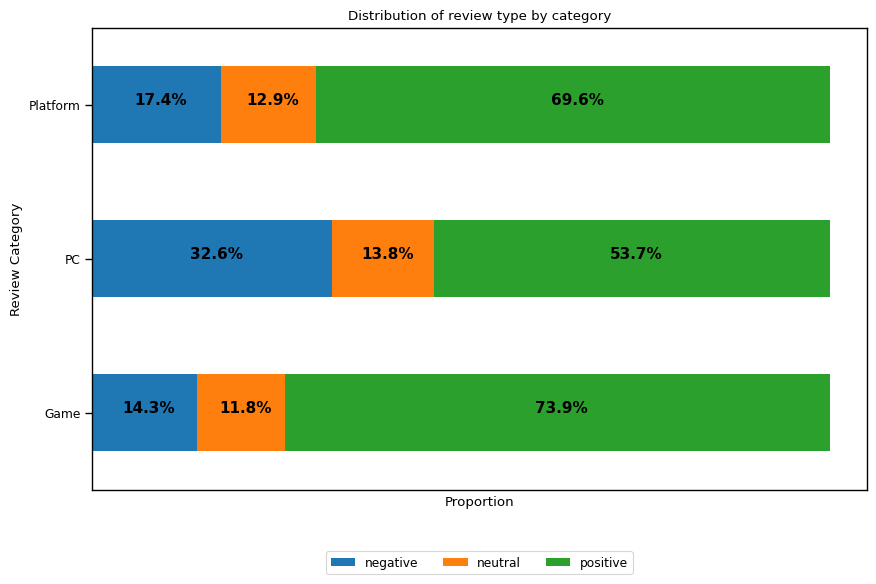

In [24]:
cross_tab_reviews = pd.crosstab(index=df['review_category'],
                        columns=df['review_type'],
                        normalize='index')

stacked_bar(cross_tab_reviews,'Distribution of review type by category','Proportion','Review Category')

The PC category has the highest number of observations, but it is also where there is a higher percentage of negative reviews, reaching 32.6%.

## Wordclouds

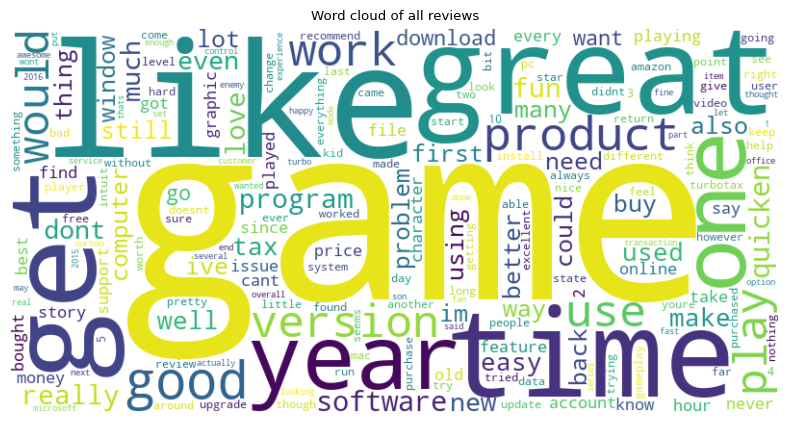

In [25]:
reviews = df['reviewText']
# Combinar todas las reviews en un único texto
all_reviews_text = " ".join(review.lower() for review in reviews if isinstance(review, str))

# Eliminar signos de puntuación utilizando expresiones regulares
all_reviews_text = re.sub(r'[^\w\s]', '', all_reviews_text)

# Obtener la lista de stopwords en inglés de NLTK
stop_words = set(stopwords.words('english'))

# Convertir el texto en una lista de palabras
word_list = all_reviews_text.lower().split()

# Filtrar las stopwords
filtered_words = [word for word in word_list if word.lower() not in stop_words]

# Realizar la lematización para agrupar palabras singulares y plurales
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

# Contar la frecuencia de cada palabra en el texto lematizado
word_freq = Counter(lemmatized_words)

# Crear la nube de palabras con las frecuencias de palabras
wordcloud = WordCloud(width=800, height=400,
                    background_color='white',
                    colormap='viridis').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of all reviews')
plt.show()

In general terms, as seen from the previous analyses, the word clouds presented below show that words with a positive meaning have a greater weight on the total dataframe.

In [26]:
def word_cloud(df,sentiment,category):
    reviews = df[(df['review_type'] == sentiment) & (df['review_category']==category)]['reviewText']
    # Combinar todas las reviews en un único texto
    all_reviews_text = " ".join(review.lower() for review in reviews if isinstance(review, str))

    # Eliminar signos de puntuación utilizando expresiones regulares
    all_reviews_text = re.sub(r'[^\w\s]', '', all_reviews_text)

    # Obtener la lista de stopwords en inglés de NLTK
    stop_words = set(stopwords.words('english'))

    # Convertir el texto en una lista de palabras
    word_list = all_reviews_text.lower().split()

    # Filtrar las stopwords
    filtered_words = [word for word in word_list if word.lower() not in stop_words]

    # Realizar la lematización para agrupar palabras singulares y plurales
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # Contar la frecuencia de cada palabra en el texto lematizado
    word_freq = Counter(lemmatized_words)

    # Crear la nube de palabras con las frecuencias de palabras
    wordcloud = WordCloud(width=800, height=400,
                        background_color='white',
                        colormap='viridis').generate_from_frequencies(word_freq)


###########################################################
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word cloud of {sentiment} reviews about {category}')
    plt.show()

### Wordclouds for Game category

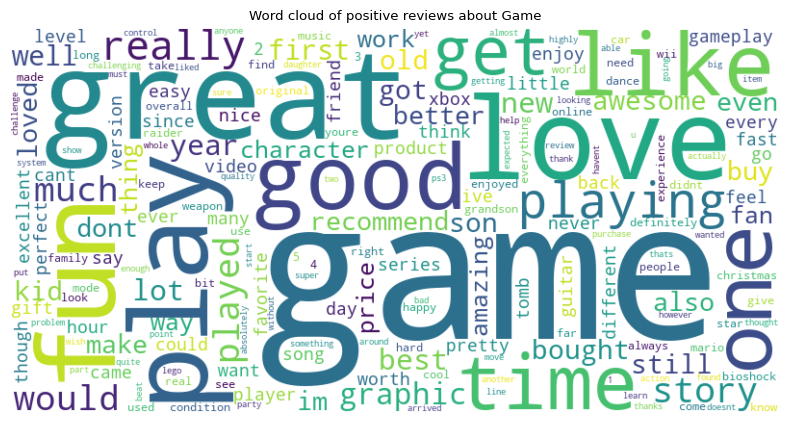

In [27]:
word_cloud(df,'positive','Game')

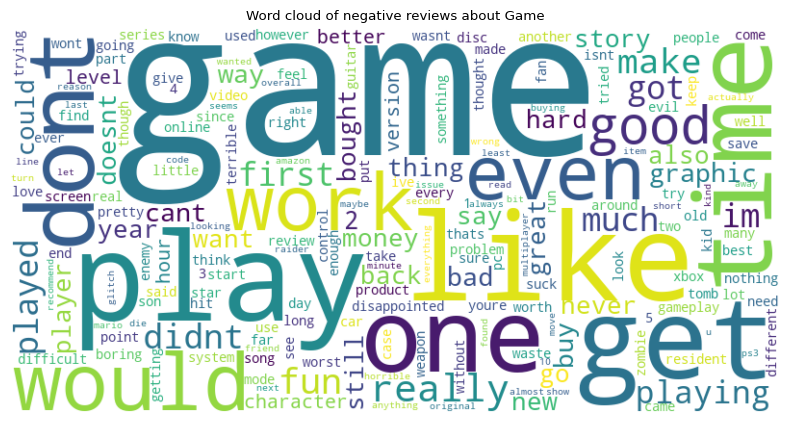

In [28]:
word_cloud(df,'negative','Game')

### Wordclouds for PC category

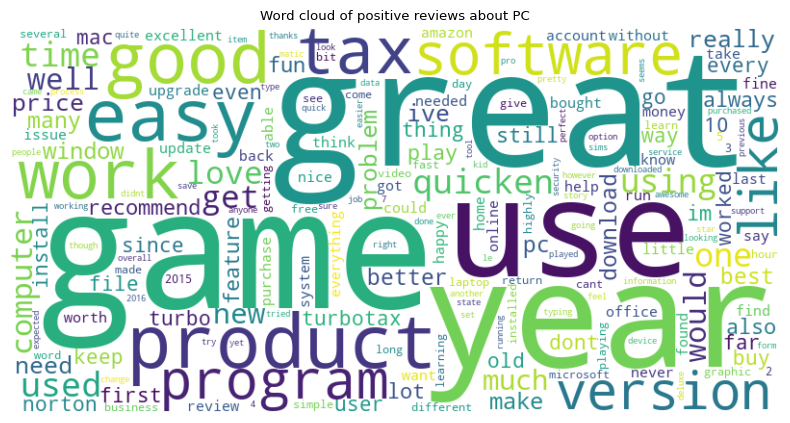

In [29]:
word_cloud(df,'positive','PC')

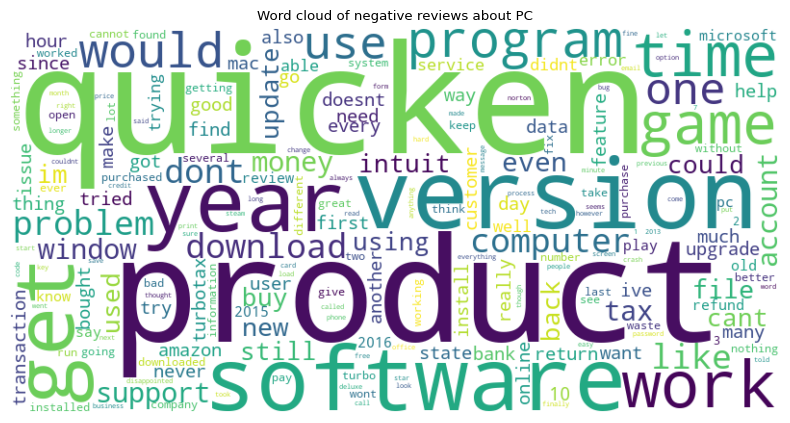

In [30]:
word_cloud(df,'negative','PC')

### Wordcloud for Platform category

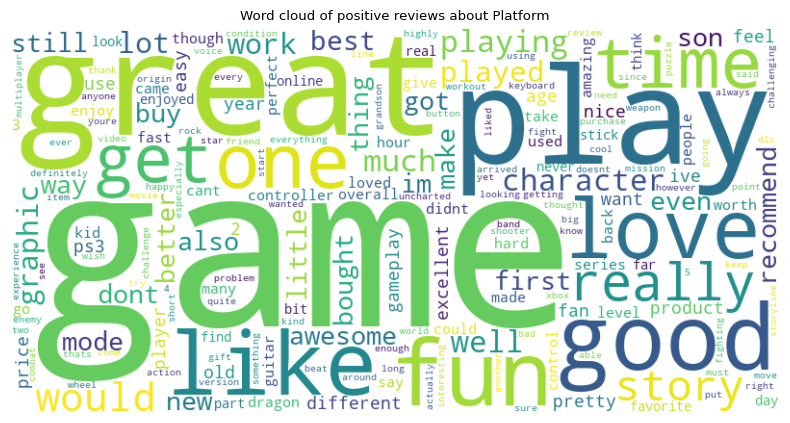

In [31]:
word_cloud(df,'positive','Platform')

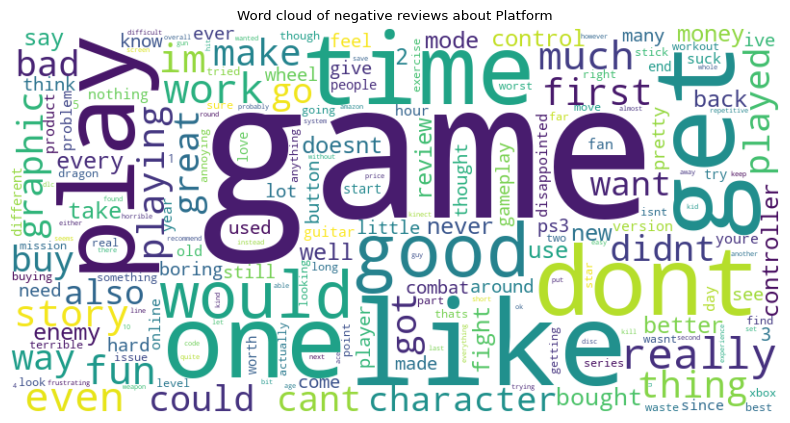

In [32]:
word_cloud(df,'negative','Platform')

The word clouds presented by category and sentiment give some insights that could be actionable for the customer service and logistics team, as when reviews are negative, some words related to delivery times stand out, possibly due to delivery delays.

## Conclussions:
* We found that in the sample data we have, most reviews have an overall rating of 5 points.
* 5 point reviews tend to have more repeated reviewers than the others.
* Users interact more with the 5 point reviews, but they also interact with the 1 point reviews. It seems that users tend to be more supportive of reviews that are very positive or very negative. Considering that the number of 5-star reviews is much higher, this does not seem worrying.
* Reviews with an overall rating of 5 show an anomalous behaviour compared to the others. There may be several reasons for this.
* Data sample may be unbalanced and that in reality the reviews are more evenly distributed across the different ratings.
* The phenomenon we see in the report corresponds to reality, and that users tend to be more supportive of positive reviews and more likely to share positive comments about the products they see.
*  The reviews are skewed by bot activity or paid reviews.
*  Analysis made for games and tech reviews showed that there are a bias to give review when the overall is higher.
*  The sentiment analysis showed that Amazon had products with a great adoption by the public, in general with good reviews.
*  It is necessary to add features to the dataset in order to analyze by age and see trends in the quantity and type of reviews in order to generate improvements in logistics and quality assurance processes in the products offered and distributed.

## Takeaways:
1. Generate an optimized pipeline that allows the extraction, transformation and loading of data in an appropriate way, accompanied by a process supported by pyspark to perform sentiment analysis in a short time.
2. Make a deploy of the algorithm and design a dashboard in order to give information in real-time to the main stakeholders.



In [33]:
%%capture
!jupyter nbconvert --to html --no-input --no-prompt Presentation_Datathon_3.ipynb
